In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jaxmao.layers import Conv2D, Dense, BatchNorm, ReLU, Flatten, StableSoftmax
from jaxmao.modules import Module
from jaxmao.optimizers import GradientDescent
from jaxmao.losses import CategoricalCrossEntropy
from jaxmao.metrics import Accuracy

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
seed = 42
key = jax.random.PRNGKey(seed)

I0000 00:00:1697767609.564137   10933 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
data = datasets.load_digits()
image, label = data['images'], data['target']

X_train, X_test, y_train, y_test = train_test_split(image, label, test_size=0.2, random_state=seed)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

enc = OneHotEncoder(sparse_output=False)
y_train_enc = enc.fit_transform(np.expand_dims(y_train, axis=1))
y_test_enc = enc.transform(np.expand_dims(y_test, axis=1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 8, 8, 1), (360, 8, 8, 1), (1437,), (360,))

In [4]:
class DigitClassifier(Module):
    def __init__(self):
        super().__init__()
        self.add('conv1', Conv2D(1, 16, (3, 3), 1))
        self.add('flatten', Flatten())
        self.add('bn1', BatchNorm(16))
        self.add('fc1', Dense(16, 16, activation=ReLU()))
        self.add('bn2', BatchNorm(16))
        self.add('fc2', Dense(16, 10, activation=StableSoftmax()))
    
    def forward(self, params, x, state):
        x, state = self.forward_with_state(params, x, 'conv1', state)
        # x, state = self.forward_with_state(params, x, 'flatten', state)
        x, state = self.forward_with_state(params, x, 'bn1', state)
        # x, state = self.forward_with_sta  te(params, x, 'fc1', state)
        # x, state = self.forward_with_state(params, x, 'bn2', state)
        # x, state = self.forward_with_state(params, x, 'fc2', state)
        return x, state
    
clf = DigitClassifier()
clf.init_params(key)

clf.forward = jax.jit(clf.forward)
clf.pure_forward = jax.jit(clf.pure_forward)

out, state = clf.pure_forward(clf.params, X_test, clf.state)
out.shape, type(out), type(state)

((360, 8, 8, 16), jaxlib.xla_extension.ArrayImpl, dict)

In [19]:
clf.layers['bn1'].shapes

{'gamma': (1, 16), 'beta': (16,)}

In [14]:
from sklearn.utils import shuffle

criteria = CategoricalCrossEntropy()
criteria.calculate_loss = jax.jit(criteria.calculate_loss)
def loss_fn(model, params, x_true, y_true, state,
            criteria
            ):
    y_pred, new_state = model.pure_forward(params, x_true, state)
    loss = criteria.calculate_loss(y_pred, y_true)
    return loss, new_state

val_grad_loss_fn = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)
def training_loop(
    model, optimizer, x_true, y_true,
    epochs, lr=0.01, batch_size=16
):
    num_batch = len(x_true) // batch_size 
    for epoch in range(epochs):
        losses = 0.0
        x_true, y_true = shuffle(x_true, y_true)
        for n in range(num_batch):
            batch_x = x_true[n*batch_size:(n+1)*batch_size]
            batch_y = y_true[n*batch_size:(n+1)*batch_size]
            (loss, new_state), gradients = val_grad_loss_fn(model, model.params, 
                                                            batch_x, 
                                                            batch_y, 
                                                            model.state, 
                                                            criteria)
            losses = losses + loss
            model.params, optim_state = optimizer.step(model.params, gradients, lr=lr)
            model.update_state(new_state)
        
        accuracy = Accuracy()(model(model.params, batch_x), batch_y.argmax(axis=1))
        print('epoch {}: {}, {}'.format(epoch, losses/num_batch, accuracy))

In [15]:
optimizer = GradientDescent()
epochs = 10
lr = 0.01

training_loop(clf, 
              optimizer, 
              X_train, 
              y_train_enc, 
              epochs=epochs, lr=lr, batch_size=16
              )

ValueError: Incompatible shapes for broadcasting: shapes=[(16, 10), (16, 8, 8, 16)]

In [ ]:
y_pred = clf(clf.params, X_test)

In [ ]:
Accuracy().calculate(y_pred.argmax(axis=1), y_test)

Array(0.9638889, dtype=float32)

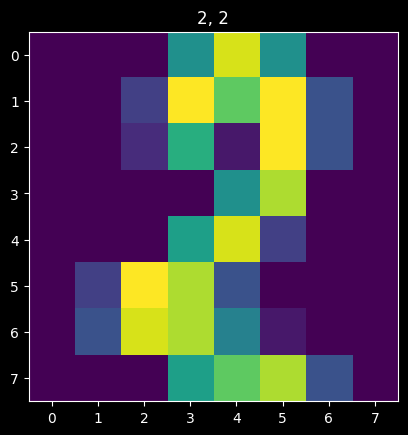

In [ ]:
index = np.random.randint(0, len(X_test))
plt.imshow(X_test[index])
plt.title(f'{y_test[index]}, {y_pred[index].argmax()}')
plt.show()

# using .fit()!!!

In [ ]:
clf = DigitClassifier()
clf.init_params(key)

out = clf(clf.params, X_test)
out.shape

(360, 10)

In [ ]:
clf.compile(
    loss_fn=CategoricalCrossEntropy(),
    optimizer=GradientDescent(),
    metrics=Accuracy()
)
clf.fit(X_train, y_train_enc, lr=0.01, epochs=5)

epoch 0: Loss 3.0322628021240234; accuracy: 0.9751420617103577
epoch 1: Loss 3.216646432876587; accuracy: 0.96875
epoch 2: Loss 2.399807929992676; accuracy: 0.9808238744735718
epoch 3: Loss 1.7255582809448242; accuracy: 0.9850852489471436
epoch 4: Loss 1.9668234586715698; accuracy: 0.9822443723678589
